In [195]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics.classification import BinaryAccuracy, MultilabelAccuracy

plt.style.use("dark_background")

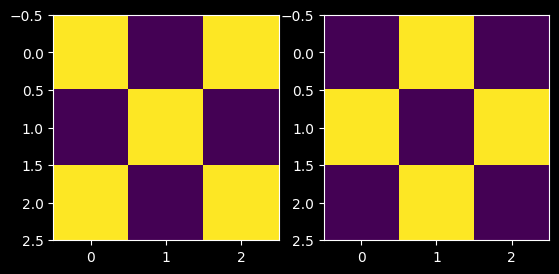

In [235]:
cross = np.array([
    [1, 0, 1],
    [0, 1, 0],
    [1, 0, 1],
])
plus = np.array([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0],
])

dimension = height, width = plus.shape

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.imshow(cross)
ax2.imshow(plus)

In [236]:
def fill_boards(blank_shape, piece):
    blank = np.zeros(blank_shape)
    height, width = piece.shape

    fills = []
    for i in range(0, blank.shape[0], height):
        for j in range(0, blank.shape[1], width):
            board = blank.copy()
            board[i:i + height, j:j + width] = piece
            fills.append(board)
    
    return np.array(fills)

In [237]:
def plot_pieces(boards):
    halfed = np.sqrt(boards.shape[0])
    halfed = int(halfed)
    _, axes = plt.subplots(nrows=halfed, ncols=halfed)
    
    for board, ax in zip(boards, axes.flat):
        ax.imshow(board)

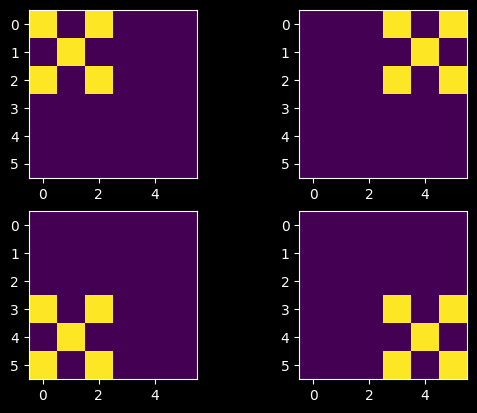

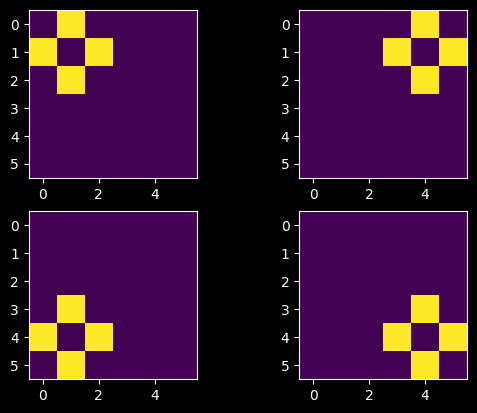

In [238]:
cross_boards = fill_boards((6, 6), cross)
plus_boards = fill_boards((6, 6), plus)

plot_pieces(cross_boards)
plot_pieces(plus_boards)

In [239]:
crosses = torch.tensor(cross_boards, dtype=torch.float).unsqueeze(1)
pluses = torch.tensor(plus_boards, dtype=torch.float).unsqueeze(1)

cross_labels = torch.tensor([[1, 0]] * crosses.shape[0], dtype=torch.float)
plus_labels = torch.tensor([[0, 1]] * pluses.shape[0], dtype=torch.float)

data_images = torch.concat([
    crosses,
    pluses,
])

data_labels = torch.concat([
    cross_labels,
    plus_labels,
])

dataset = TensorDataset(data_images, data_labels)

In [240]:
class SymbolClassifier(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.channel = input_shape[0]
        self.height = input_shape[1]
        self.width = input_shape[2]
        
        self.conv = nn.Conv2d(self.channel, 2, (3, 3), stride=(3, 3))
        self.model = nn.Sequential(
            self.conv,
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2 * 2 * 2, 2),
            nn.Sigmoid(),
        )
    
    def forward(self, X):
        return self.model(X)
    
    def predict(self, X):
        with torch.no_grad():
            return self.model(X).detach()

Epoch 1/100: loss = 0.7002
Epoch 2/100: loss = 0.6908
Epoch 3/100: loss = 0.6822
Epoch 4/100: loss = 0.6728
Epoch 5/100: loss = 0.6617
Epoch 6/100: loss = 0.6487
Epoch 7/100: loss = 0.6332
Epoch 8/100: loss = 0.6152
Epoch 9/100: loss = 0.5944
Epoch 10/100: loss = 0.5704
Epoch 11/100: loss = 0.5421
Epoch 12/100: loss = 0.5083
Epoch 13/100: loss = 0.4689
Epoch 14/100: loss = 0.4254
Epoch 15/100: loss = 0.3767
Epoch 16/100: loss = 0.3262
Epoch 17/100: loss = 0.2779
Epoch 18/100: loss = 0.2326
Epoch 19/100: loss = 0.1913
Epoch 20/100: loss = 0.1558
Epoch 21/100: loss = 0.1287
Epoch 22/100: loss = 0.1063
Epoch 23/100: loss = 0.0891
Epoch 24/100: loss = 0.0760
Epoch 25/100: loss = 0.0656
Epoch 26/100: loss = 0.0570
Epoch 27/100: loss = 0.0501
Epoch 28/100: loss = 0.0446
Epoch 29/100: loss = 0.0401
Epoch 30/100: loss = 0.0361
Epoch 31/100: loss = 0.0328
Epoch 32/100: loss = 0.0300
Epoch 33/100: loss = 0.0276
Epoch 34/100: loss = 0.0255
Epoch 35/100: loss = 0.0236
Epoch 36/100: loss = 0.0220
E

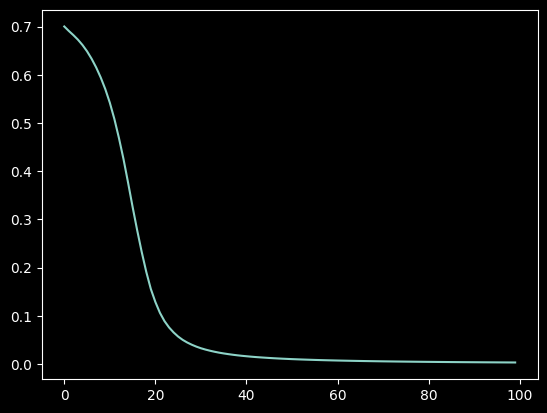

In [282]:
symbol_classifier = SymbolClassifier(crosses.shape[1:])

lr = 1
epochs = 100

criterion = nn.BCELoss()
optimizer = optim.SGD(symbol_classifier.parameters(), lr=lr)
data_loader = DataLoader(dataset, batch_size=len(dataset))

losses = []
for epoch in range(1, epochs + 1):
    total_loss = 0
    for image, label in data_loader:
        yhat = symbol_classifier.forward(image)
        loss = criterion(yhat, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    total_loss /= len(data_loader)
    losses.append(total_loss)
    print(f"Epoch {epoch}/{epochs}: loss = {total_loss:,.4f}")


plt.plot(losses)

In [283]:
get_accuracy = MultilabelAccuracy(2)
y_pred = symbol_classifier.predict(data_images)
accuracy = get_accuracy(y_pred, data_labels)

print(f"Loss: {losses[-1]:.4f}")
print(f"Accuracy: {accuracy:.2%}")

Loss: 0.0032
Accuracy: 100.00%


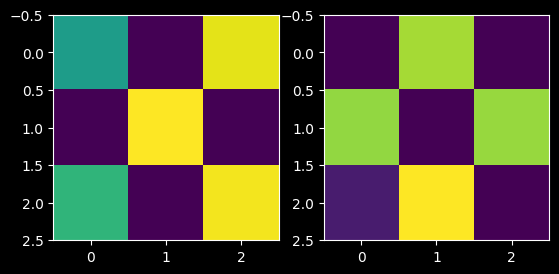

In [284]:
cross_kernel, plus_kernel = symbol_classifier.state_dict()['conv.weight'].relu()

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.imshow(cross_kernel[0])
ax2.imshow(plus_kernel[0])

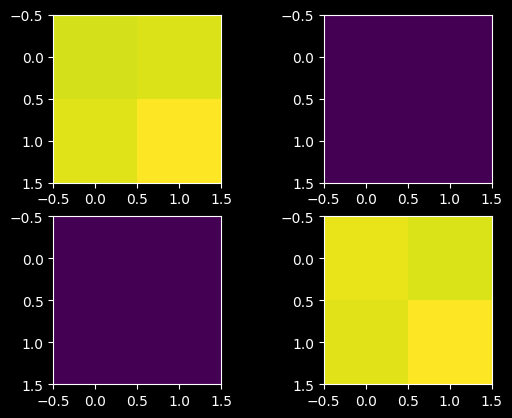

In [285]:
cross_out, plus_out = symbol_classifier.state_dict()['model.3.weight'].relu()
cross_out_vmin = cross_out.min()
cross_out_vmax = cross_out.max()
plus_out_vmin = plus_out.min()
plus_out_vmax = plus_out.max()

cross_sub1, cross_sub2 = cross_out.reshape(2, 2, 2)
plus_sub1, plus_sub2 = plus_out.reshape(2, 2, 2)

fig, axes = plt.subplots(nrows=2, ncols=2)
ax1, ax2, ax3, ax4 = axes.ravel()

ax1.imshow(cross_sub1, vmin=0, vmax=cross_out_vmax)
ax2.imshow(cross_sub2, vmin=0, vmax=cross_out_vmax)

ax3.imshow(plus_sub1, vmin=0, vmax=plus_out_vmax)
ax4.imshow(plus_sub2, vmin=0, vmax=plus_out_vmax)

tensor([[0.5848, 0.5848],
        [0.5848, 0.0000]])
tensor([[0.5892, 0.5892],
        [0.5892, 6.0438]])


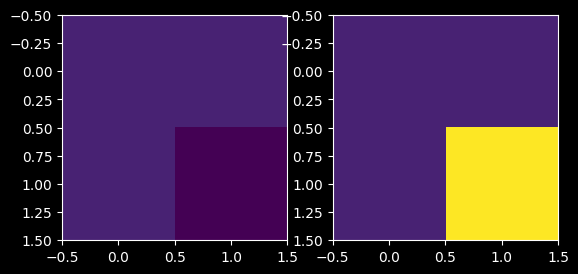

In [290]:
feature_map1, feature_map2 = symbol_classifier.conv(data_images)[7].detach().relu()

feature_map_vmax = max(feature_map1.max(), feature_map2.max())

print(feature_map1)
print(feature_map2)

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.imshow(feature_map1,vmin=0,vmax=feature_map_vmax)
ax2.imshow(feature_map2,vmin=0,vmax=feature_map_vmax)